# Bank Marketing

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans

In [81]:
df=pd.read_csv('C:\\Users\\User\\Downloads\\Untitled Folder\\termdeposit_train.csv')
df.shape

(31647, 18)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          31647 non-null  int64 
 1   age         31647 non-null  int64 
 2   job         31647 non-null  object
 3   marital     31647 non-null  object
 4   education   31647 non-null  object
 5   default     31647 non-null  object
 6   balance     31647 non-null  int64 
 7   housing     31647 non-null  object
 8   loan        31647 non-null  object
 9   contact     31647 non-null  object
 10  day         31647 non-null  int64 
 11  month       31647 non-null  object
 12  duration    31647 non-null  int64 
 13  campaign    31647 non-null  int64 
 14  pdays       31647 non-null  int64 
 15  previous    31647 non-null  int64 
 16  poutcome    31647 non-null  object
 17  subscribed  31647 non-null  object
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


job,marital,education,default,housing.loan,contact,month,poutcome are categorical variables

In [83]:
df.isna().sum()

ID            0
age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

No Null values , no imputation required.

In [84]:
df.head()
# df.describe()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


# Exploratory Data Analysis

<Axes: xlabel='age'>

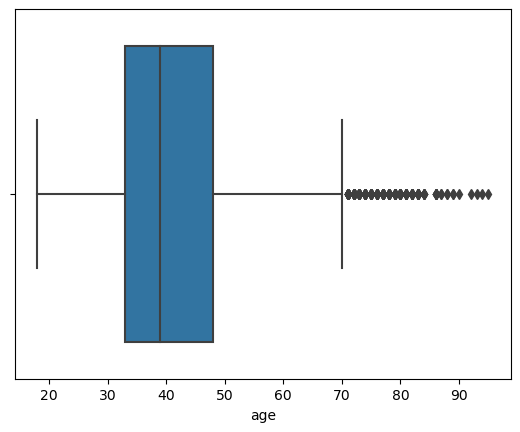

In [85]:
sns.boxplot(x=df["age"])

Median Age is 40

<Axes: xlabel='age', ylabel='job'>

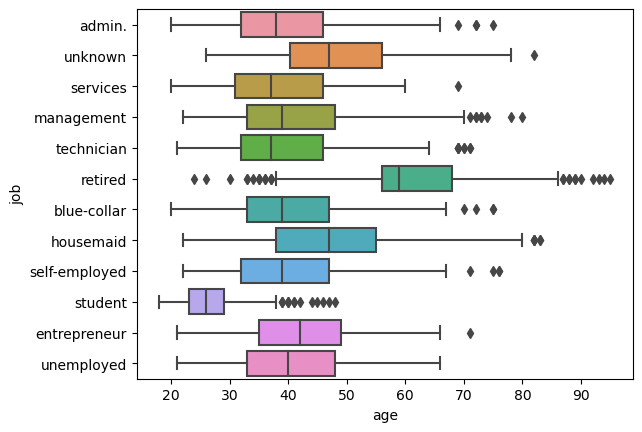

In [86]:
sns.boxplot(x=df["age"],y=df['job'])

student and retired have outliers in age which may cause false predictions. Let us handle outliers of age with Q3+1.5IQR ->> Q3 and Q1-1.5IQR ->> Q1 

In [88]:
def remove_outliers(df):
    # Step 1: Compute Q1 and Q3 for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    # Step 2: Compute IQR for each column
    IQR = Q3 - Q1
    
    # Step 3: Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Step 4: Replace outliers with nearest quartile value
    for col in ['age']:
        df[col] = df[col].mask(df[col] < lower_bound[col], Q1[col]).mask(df[col] > upper_bound[col], Q3[col])
    
    return df
for i in ['student','retired']:
    df[df['job']==i]=remove_outliers(df[df['job']==i])

C:\Users\User\AppData\Local\Temp\ipykernel_15060\3536060940.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\User\AppData\Local\Temp\ipykernel_15060\3536060940.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\User\AppData\Local\Temp\ipykernel_15060\3536060940.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].m

<Axes: xlabel='age', ylabel='marital'>

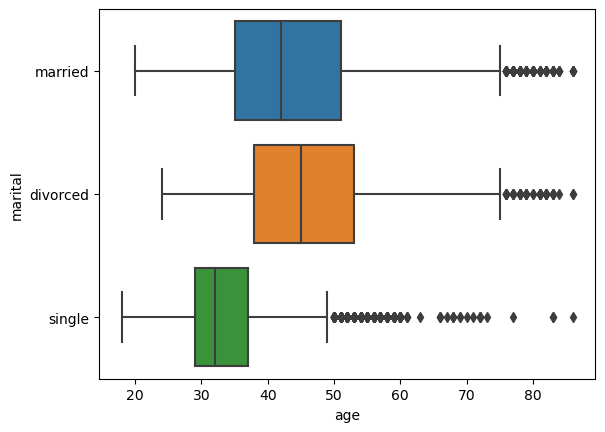

In [89]:
sns.boxplot(x=df['age'],y=df['marital'])

Single median age is near 30 whereas married and divorced age is nearly 45

<Axes: xlabel='age', ylabel='month'>

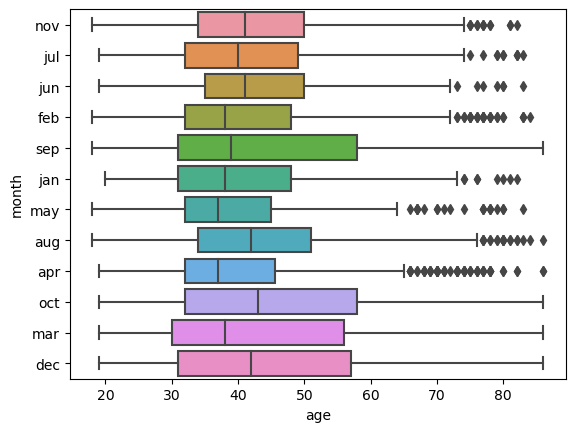

In [90]:
sns.boxplot(x=df['age'],y=df['month'])

People of High age are targeted in the first few months of the financial year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'admin.'),
  Text(1, 0, 'unknown'),
  Text(2, 0, 'services'),
  Text(3, 0, 'management'),
  Text(4, 0, 'technician'),
  Text(5, 0, 'retired'),
  Text(6, 0, 'blue-collar'),
  Text(7, 0, 'housemaid'),
  Text(8, 0, 'self-employed'),
  Text(9, 0, 'student'),
  Text(10, 0, 'entrepreneur'),
  Text(11, 0, 'unemployed')])

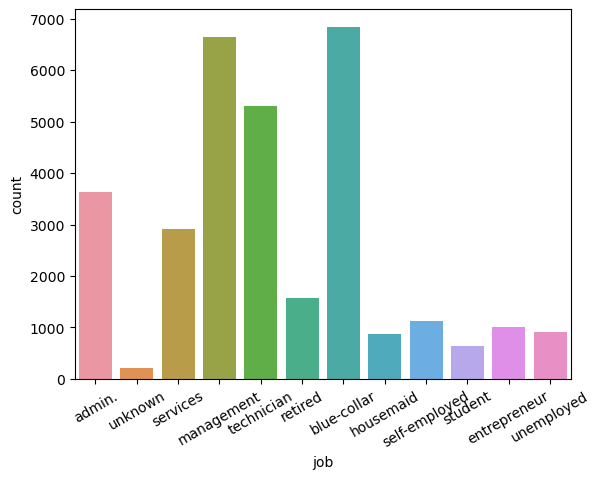

In [91]:
sns.countplot(x=df['job'])
plt.xticks(rotation=30)

Blue collar and management job holders are the most contacted people.

(array([0, 1, 2]),
 [Text(0, 0, 'married'), Text(1, 0, 'divorced'), Text(2, 0, 'single')])

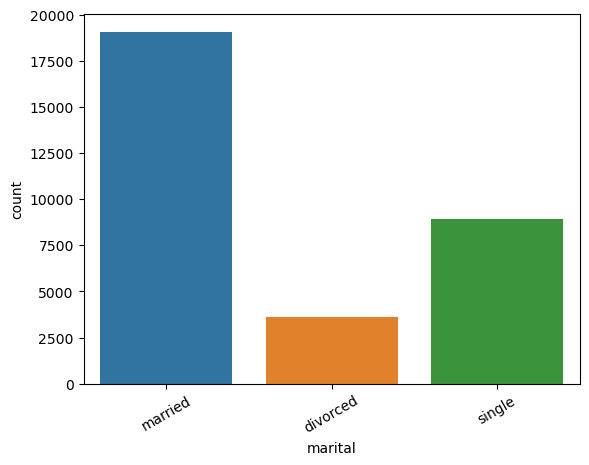

In [92]:
sns.countplot(x=df['marital'])
plt.xticks(rotation=30)

Most Married people ar targeted because of their interest on investing.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'nov'),
  Text(1, 0, 'jul'),
  Text(2, 0, 'jun'),
  Text(3, 0, 'feb'),
  Text(4, 0, 'sep'),
  Text(5, 0, 'jan'),
  Text(6, 0, 'may'),
  Text(7, 0, 'aug'),
  Text(8, 0, 'apr'),
  Text(9, 0, 'oct'),
  Text(10, 0, 'mar'),
  Text(11, 0, 'dec')])

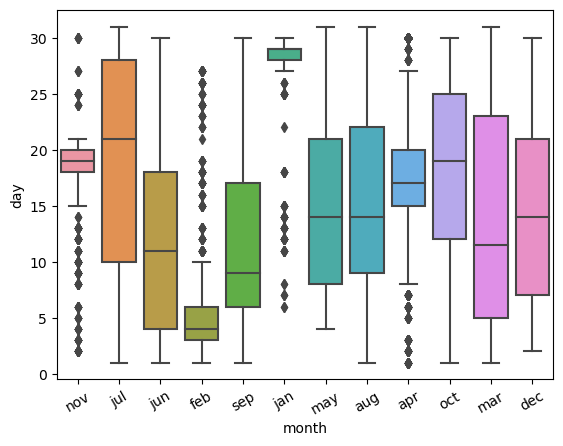

In [93]:
sns.boxplot(x=df['month'],y=df['day'])
plt.xticks(rotation=30)

Jan and Feb months alone people are targeted at end and start of the month

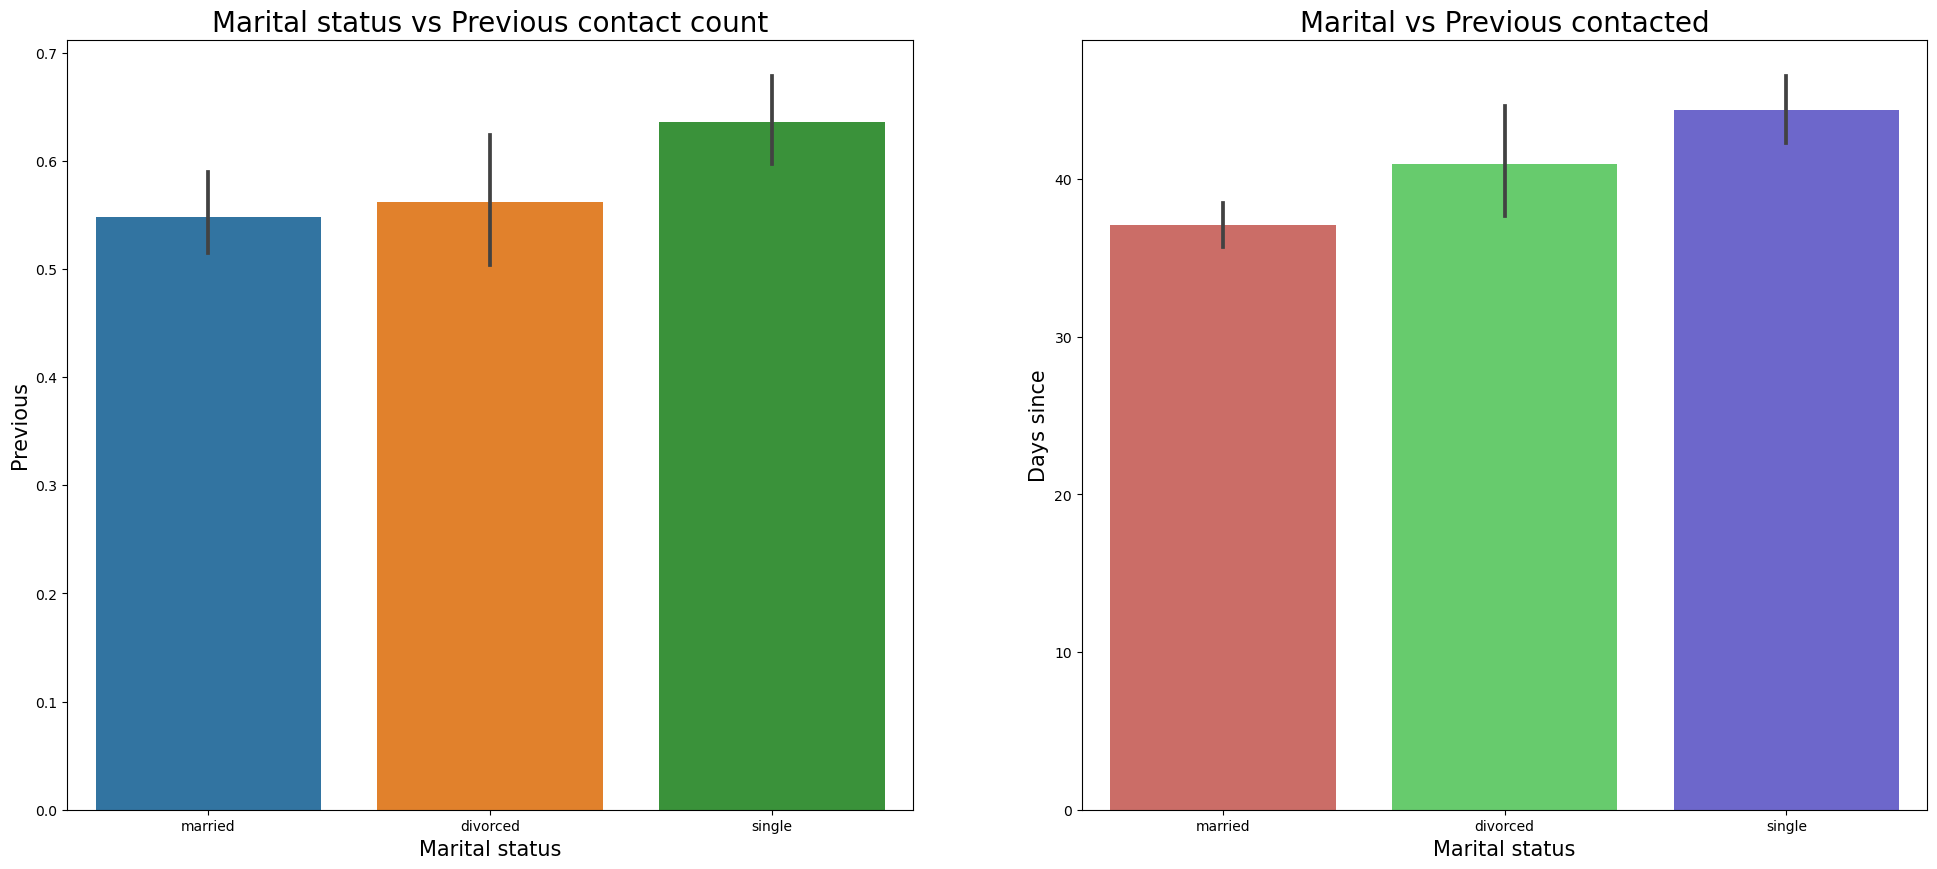

In [94]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.barplot(x='marital',y='previous',data=df)
plt.title('Marital status vs Previous contact count',fontsize=20)
plt.xlabel('Marital status',fontsize=15)
plt.ylabel('Previous',fontsize=15)
plt.subplot(1,2,2)
sns.barplot(x='marital',y='pdays',data=df,palette='hls')
plt.title('Marital vs Previous contacted',fontsize=20)
plt.xlabel('Marital status',fontsize=15)
plt.ylabel('Days since',fontsize=15)
plt.show()

Students are contacted more and earlier . May imply they are targeted more and need time to convince.

<Axes: xlabel='poutcome', ylabel='count'>

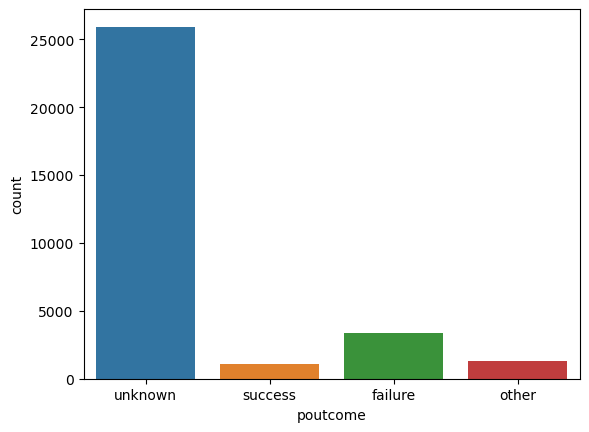

In [95]:
# Success rate in the previous campaign
sns.countplot(x='poutcome',data=df)

Most of the poutcome is unknown

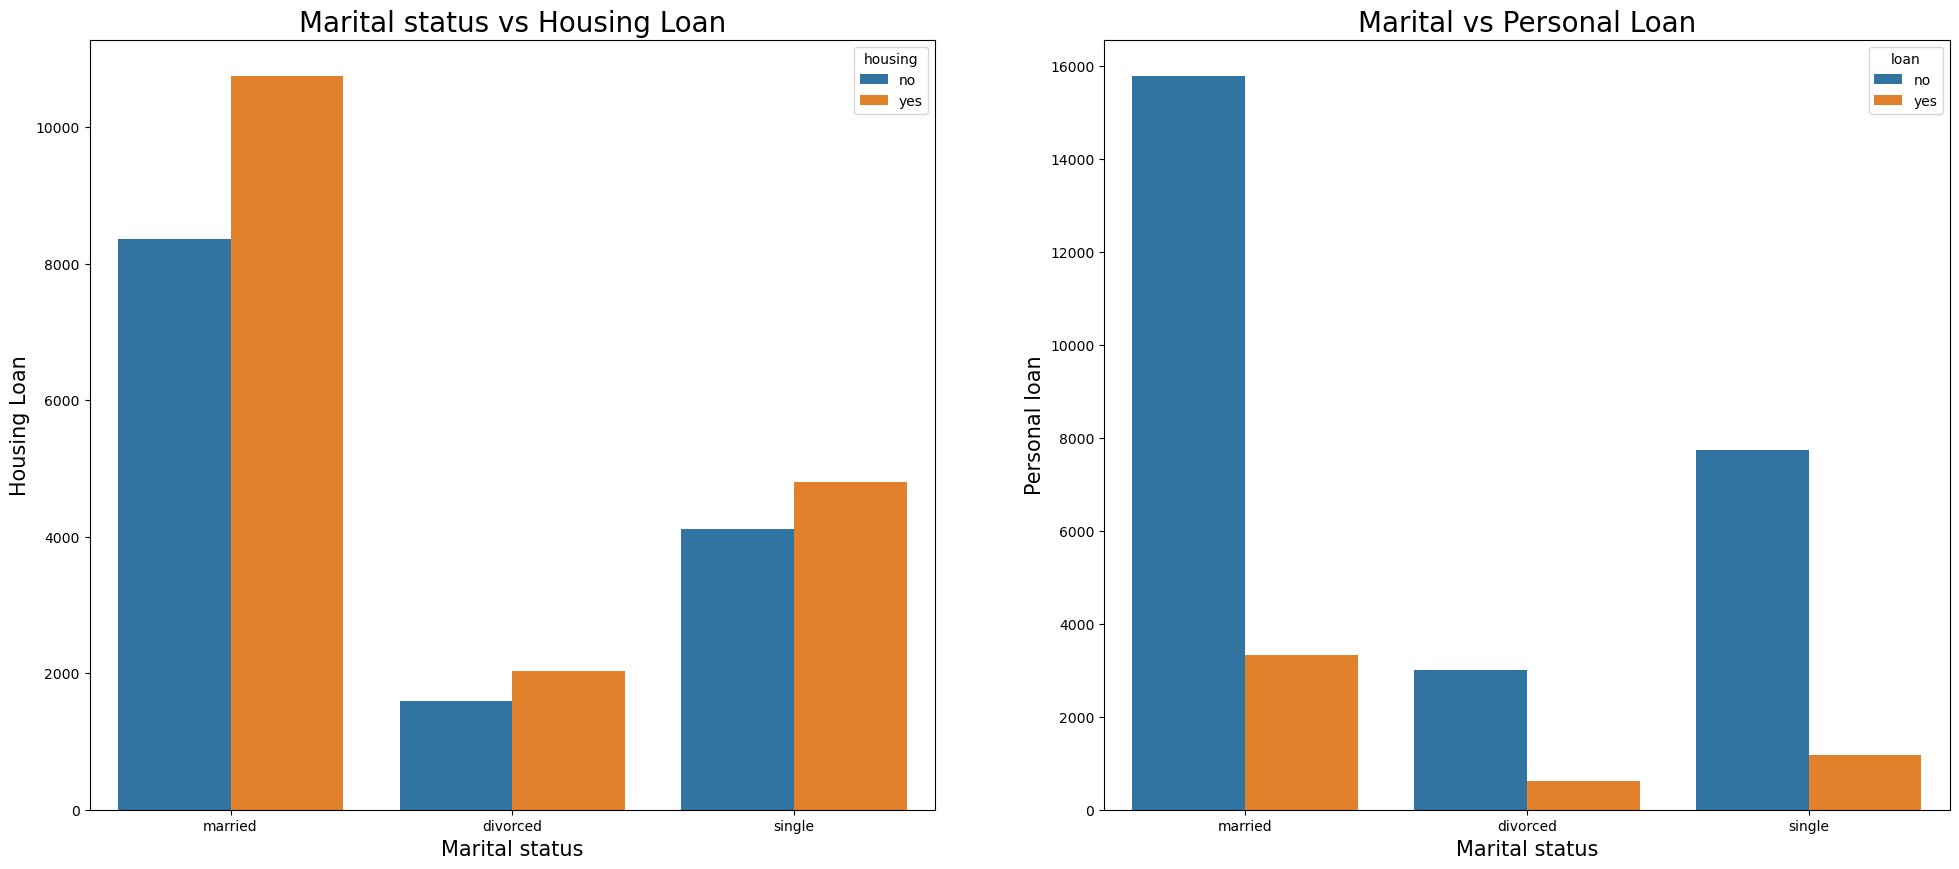

In [100]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.countplot(x='marital',data=df,hue='housing')
plt.title('Marital status vs Housing Loan',fontsize=20)
plt.xlabel('Marital status',fontsize=15)
plt.ylabel('Housing Loan',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='marital',data=df,hue='loan')
plt.title('Marital vs Personal Loan',fontsize=20)
plt.xlabel('Marital status',fontsize=15)
plt.ylabel('Personal loan',fontsize=15)
plt.show()

housing         no                 yes                 All
loan            no       yes        no       yes          
marital                                                   
divorced  0.040952  0.009416  0.054002  0.010333  0.114703
married   0.225171  0.038771  0.273359  0.066073  0.603375
single    0.112838  0.017221  0.131545  0.020318  0.281922
All       0.378962  0.065409  0.458906  0.096723  1.000000


<Axes: xlabel='housing-loan', ylabel='marital'>

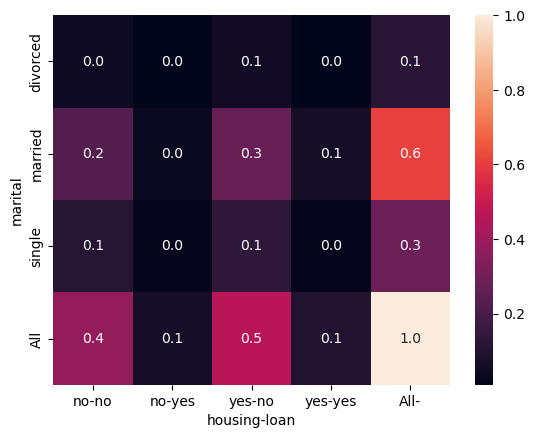

In [114]:
melted_df = pd.crosstab(df.marital,columns=[df.housing,df.loan],margins=True,normalize=True)
print(melted_df)
sns.heatmap(melted_df,annot=True,fmt='0.01f')

Married are preferring more housing loans.Personal loans are least preferred. 40% people are not preferring any loans.

0    27932
1     3715
Name: subscribed, dtype: int64


<Axes: xlabel='subscribed', ylabel='count'>

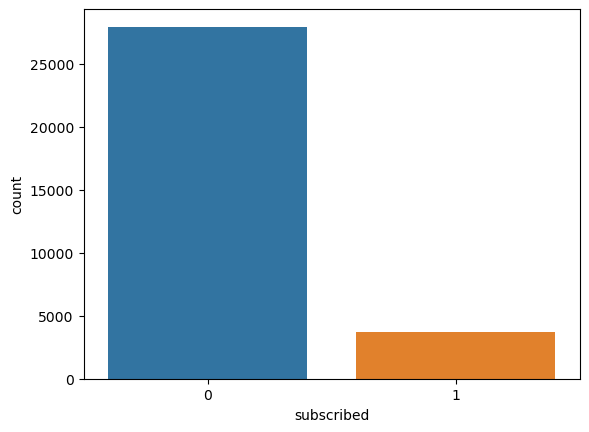

In [134]:
# Count of Target variable
print(df['subscribed'].value_counts())
sns.countplot(x=df['subscribed'])
    

The Yes subscribed category is undersampled.

In [149]:
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])
df=pd.get_dummies(df)

In [150]:
# storing the Dependent Variables in X and Independent Variable in Y
x=df.drop(['ID'],axis=1)
y=df['subscribed']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)

In [151]:
sm=SMOTE(random_state=21)
x_train,y_train=sm.fit_resample(x_train,y_train)

In [152]:
x_train.shape

(39094, 17)

In [153]:
x_train=x_train.drop(['subscribed'],axis=1)
x_test=x_test.drop(['subscribed'],axis=1)

Multicollinearity

In [154]:
vif_data = pd.DataFrame()
vif_data["Variable"] = x_train.columns
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]


In [155]:
vif_data

,Variable,VIF
0,age,12.035632
1,job,3.116919
2,marital,4.225549
3,education,3.726445
4,default,1.026563
5,balance,1.295554
6,housing,1.944255
7,loan,1.155091
8,contact,1.727101
9,day,4.785373


age and poutcome > 5 let us remove those variables

In [156]:
x_train=x_train.drop(['age','poutcome'],axis=1)

In [158]:
clf1 = SVC()
clf1.fit(x_train, y_train)

SVC()

In [159]:
x_test=x_test.drop(['age','poutcome'],axis=1)
accuracy = clf1.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.771563981042654


In [161]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have trained your model and obtained predictions
y_pred_svm = clf1.predict(x_test)

# Compare y_test and y_pred using accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred_svm)
print("Classification Report:\n", class_report)

Accuracy: 0.771563981042654
Confusion Matrix:
 [[6592 1793]
 [ 376  734]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86      8385
           1       0.29      0.66      0.40      1110

    accuracy                           0.77      9495
   macro avg       0.62      0.72      0.63      9495
weighted avg       0.87      0.77      0.81      9495



In [162]:
clf2 = LogisticRegression()
clf2.fit(x_train, y_train)
# Assuming you have trained your model and obtained predictions
y_pred_lr = clf2.predict(x_test)

# Compare y_test and y_pred using accuracy score
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred_lr)
print("Classification Report:\n", class_report)

Accuracy: 0.7992627698788837
Confusion Matrix:
 [[6820 1565]
 [ 341  769]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.88      8385
           1       0.33      0.69      0.45      1110

    accuracy                           0.80      9495
   macro avg       0.64      0.75      0.66      9495
weighted avg       0.88      0.80      0.83      9495



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [163]:
clf3 = DecisionTreeClassifier()
clf3.fit(x_train, y_train)
# Assuming you have trained your model and obtained predictions
y_pred_dtc = clf3.predict(x_test)

# Compare y_test and y_pred using accuracy score
accuracy = accuracy_score(y_test, y_pred_dtc)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dtc)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred_dtc)
print("Classification Report:\n", class_report)

Accuracy: 0.8472880463401791
Confusion Matrix:
 [[7431  954]
 [ 496  614]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      8385
           1       0.39      0.55      0.46      1110

    accuracy                           0.85      9495
   macro avg       0.66      0.72      0.68      9495
weighted avg       0.87      0.85      0.86      9495



In [164]:
clf4 = GaussianNB()
clf4.fit(x_train, y_train)
# Assuming you have trained your model and obtained predictions
y_pred_nb = clf4.predict(x_test)

# Compare y_test and y_pred using accuracy score
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred_nb)
print("Classification Report:\n", class_report)

Accuracy: 0.6371774618220116
Confusion Matrix:
 [[5192 3193]
 [ 252  858]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75      8385
           1       0.21      0.77      0.33      1110

    accuracy                           0.64      9495
   macro avg       0.58      0.70      0.54      9495
weighted avg       0.87      0.64      0.70      9495



In [165]:
clf5 = RandomForestClassifier()
clf5.fit(x_train, y_train)
# Assuming you have trained your model and obtained predictions
y_pred_rfc = clf5.predict(x_test)

# Compare y_test and y_pred using accuracy score
accuracy = accuracy_score(y_test, y_pred_rfc)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rfc)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred_rfc)
print("Classification Report:\n", class_report)

Accuracy: 0.8748815165876778
Confusion Matrix:
 [[7600  785]
 [ 403  707]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      8385
           1       0.47      0.64      0.54      1110

    accuracy                           0.87      9495
   macro avg       0.71      0.77      0.74      9495
weighted avg       0.89      0.87      0.88      9495



In [168]:
# Initialize Logistic Regression model
rand_for = RandomForestClassifier()

# Define hyperparameters grid
param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None],  # Maximum depth of the trees
    'min_samples_split': [2],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1,],  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt']  # Number of features to consider at each split
}
# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rand_for, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8754081095313323
Confusion Matrix:
 [[7602  783]
 [ 400  710]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      8385
           1       0.48      0.64      0.55      1110

    accuracy                           0.88      9495
   macro avg       0.71      0.77      0.74      9495
weighted avg       0.89      0.88      0.88      9495



This model gives the best result among others

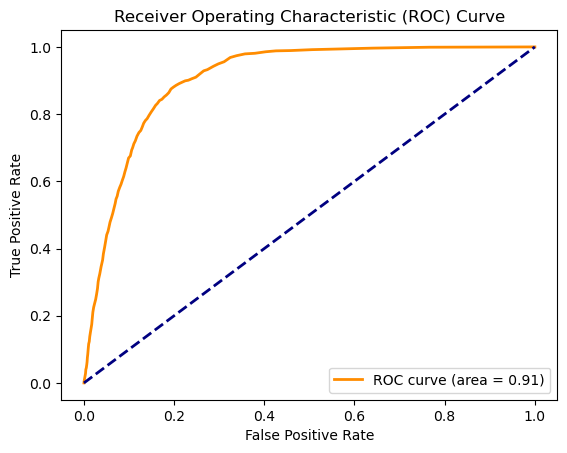

In [193]:
# Get predicted probabilities for the positive class
y_probs = grid_search.predict_proba(x_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [178]:
df_test=pd.read_csv('C:\\Users\\User\\Downloads\\Untitled Folder\\termdeposit_test.csv')
df_test.shape

(13564, 17)

In [179]:
le=LabelEncoder()
for col in df_test.columns:
    if df_test[col].dtype=='object':
        df_test[col]=le.fit_transform(df_test[col])

In [180]:
df_test=df_test.drop(['ID','age','poutcome'],axis=1)

In [181]:
df_final_pred = best_model.predict(df_test)

In [190]:
df_file=pd.read_csv('C:\\Users\\User\\Downloads\\Untitled Folder\\termdeposit_test.csv')
df_file['subscribed']=df_final_pred
df_file['subscribed']=df_file['subscribed'].replace({0:'no',1:'yes'})

In [192]:
df_file.to_csv('final_prediction_file_bm.csv',index=False)